# Sensitivity to extent

In [1]:
!make -C .. agglomeration_extracts

make: Entering directory '/home/martibosch/data-science/swiss-urbanization'
make: Nothing to be done for 'agglomeration_extracts'.
make: Leaving directory '/home/martibosch/data-science/swiss-urbanization'


In [2]:
import matplotlib.pyplot as plt
import pylandstats as pls
import swisslandstats as sls
from shapely.geometry import Point

from swiss_urbanization.data import settings

We will explore how the metrics change with respect to increasing the spatial extent of the map. We will compute the time series of metrics of the paper (see [`metrics_time_series.ipynb`](https://github.com/martibosch/swiss-urbanization/blob/master/notebooks/metrics_time_series.ipynb)) for a series of maps defined as buffers around the city center (as retrieved from the [OpenStreetMap](https://openstreetmap.org)). The considered buffer distances will be 5000m, 10000m, 15000m and 20000m. The latter buffer distance should cover the whole agglomeration extent ([as defined by the Swiss Federal Statistical Office (SFSO)](https://www.bfs.admin.ch/bfs/fr/home/statistiques/themes-transversaux/analyses-spatiales/niveaux-geographiques.assetdetail.349554.html))

In [3]:
urban_class = settings.EXTRACTS_URBAN
nodata = settings.EXTRACTS_NODATA

agglom_slugs = ['bern', 'lausanne', 'zurich']

class_metrics = [
    'proportion_of_landscape', 'area_mn', 'largest_patch_index',
    'patch_density', 'edge_density', 'fractal_dimension_am',
    'landscape_shape_index', 'euclidean_nearest_neighbor_mn'
]
landscape_metrics = ['contagion', 'shannon_diversity_index']

buffer_dists = list(range(5000, 25000, 5000))
# TODO: change hardcoded points and use overpass API filtering by tag
# `admin_centre:4=yes`
base_mask_dict = {
    'bern': Point(7.4514512, 46.9482713),
    'lausanne': Point(6.6327025, 46.5218269),
    'zurich': Point(8.5414061, 47.3769434)
}
base_mask_crs = {'init':'epsg:4326'}

In [4]:
agglom_dict = {}
for agglom_slug in agglom_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    base_mask = base_mask_dict[agglom_slug]
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                          res=ldf.res,
                          nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(ldf['FJ' +
                         urban_nonurban_column[2:4]].value_counts().index[0])
    agglom_dict[agglom_slug] = pls.SpatioTemporalBufferAnalysis(
        landscapes,
        base_mask,
        buffer_dists=buffer_dists,
        base_mask_crs=base_mask_crs,
        landscape_crs=ldf.crs,
        landscape_transform=ldf.get_transform(),
        dates=dates)

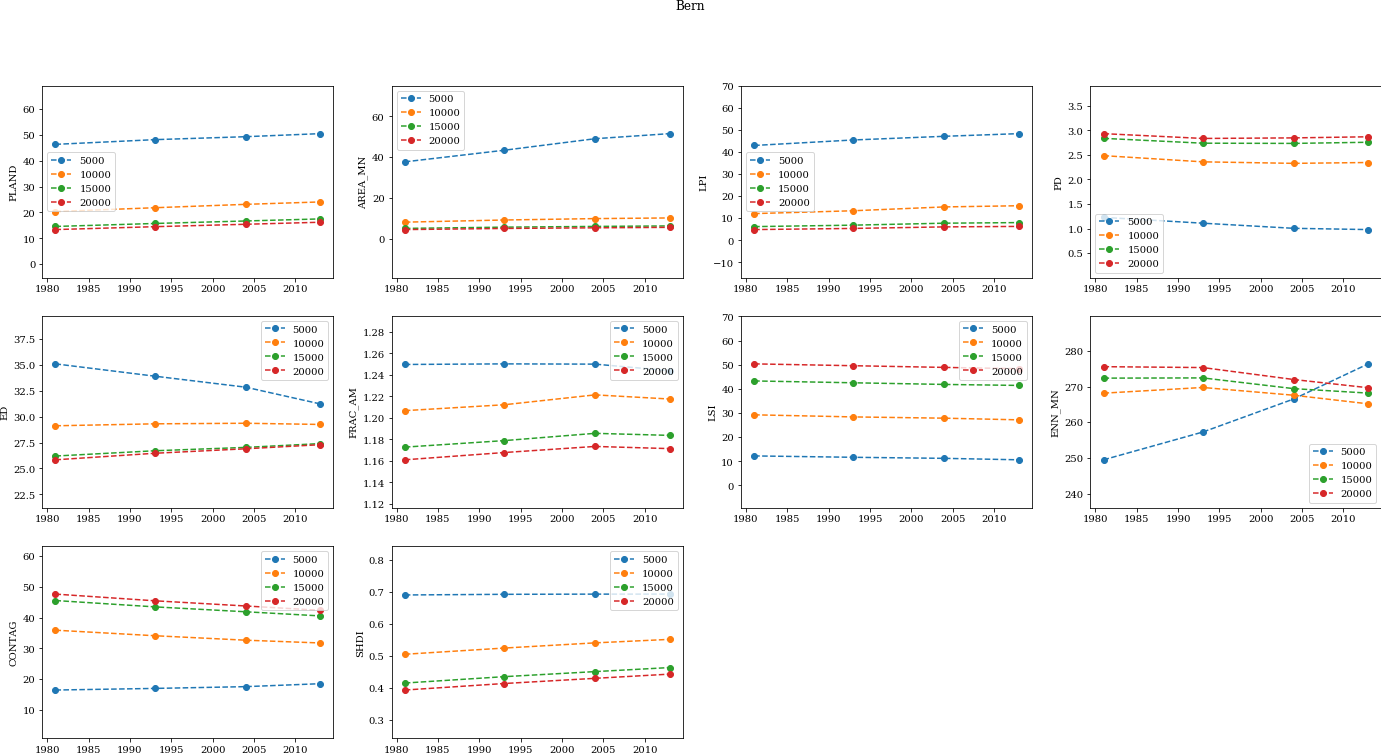

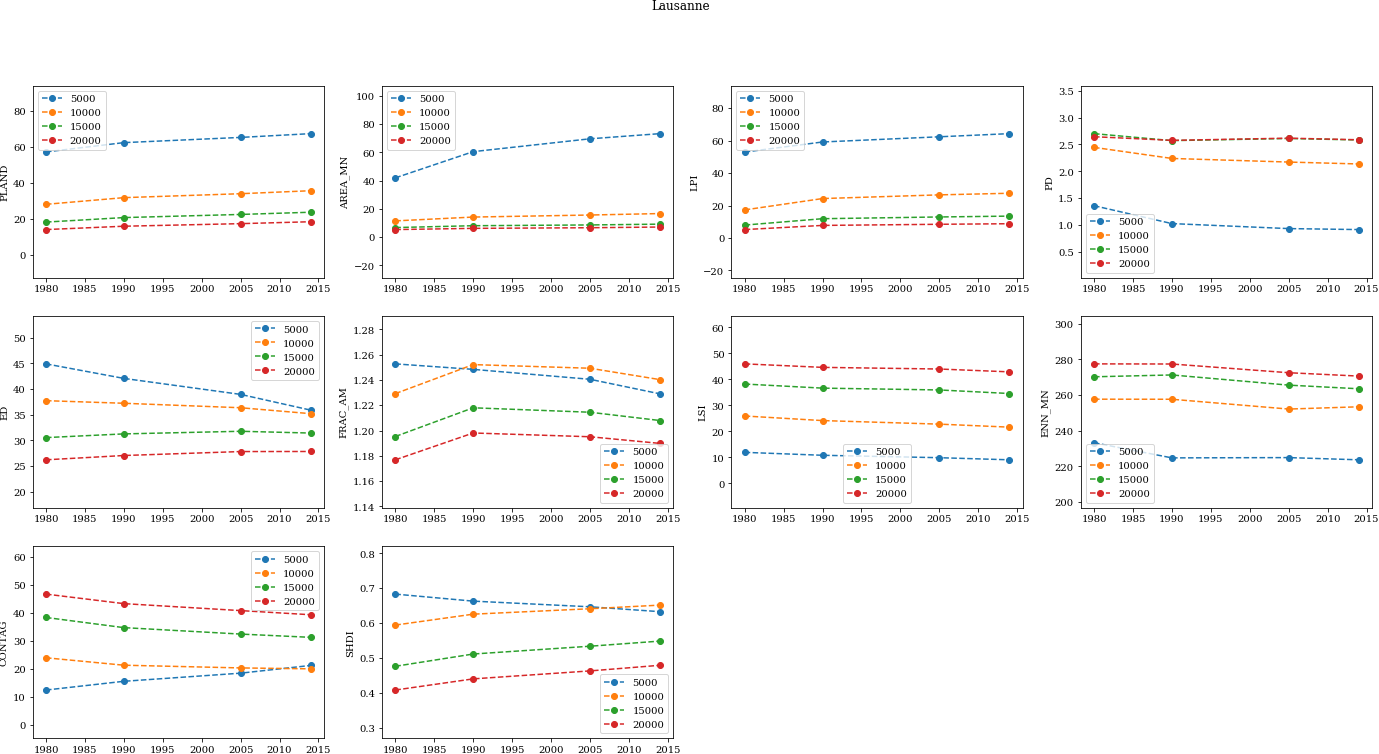

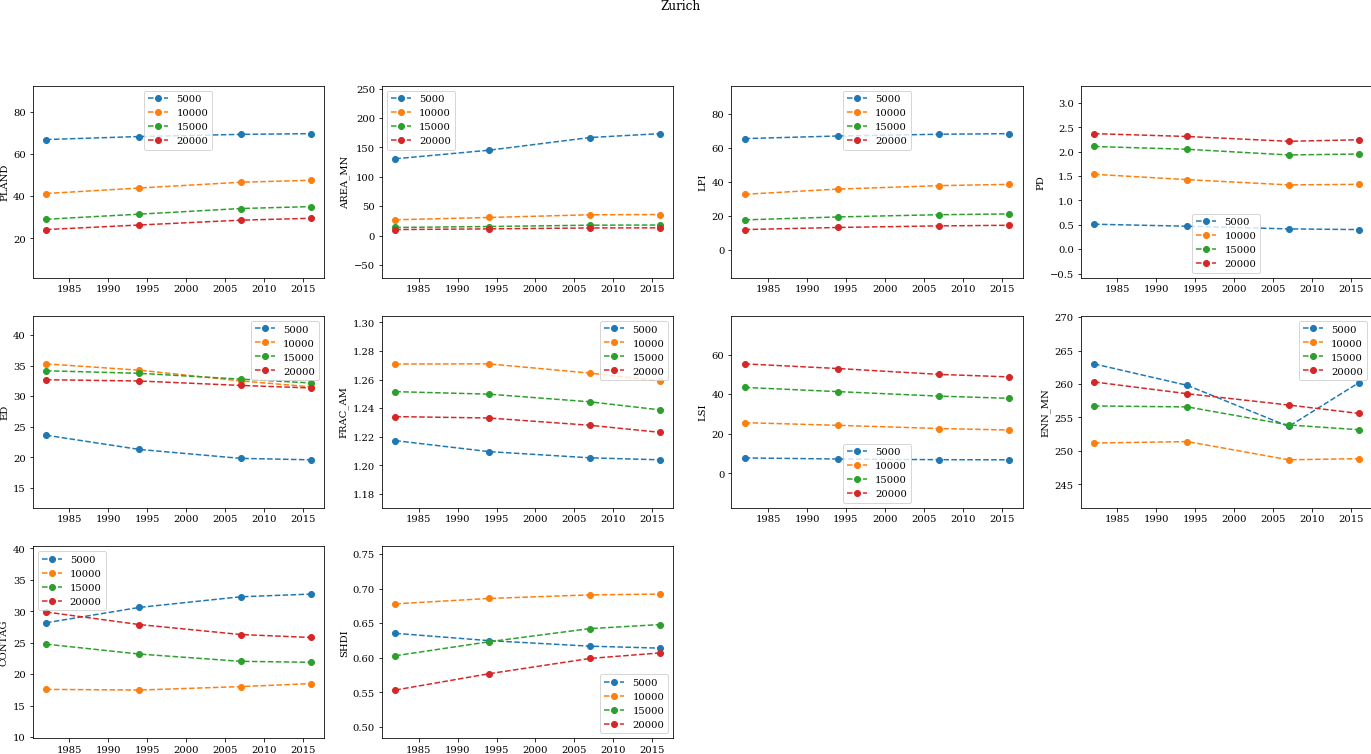

In [5]:
def plot_metric(fig,
                num_rows,
                num_cols,
                i,
                agglom_stba,
                metric,
                class_val=None):
    ax = fig.add_subplot(num_rows, num_cols, i)
    agglom_stba.plot_metric(metric, class_val=class_val, ax=ax)
    ax.margins(y=.5)
    ax.legend()


num_cols = 4
num_metrics = len(class_metrics) + len(landscape_metrics)
num_rows = num_metrics // num_cols
if num_metrics % num_cols > 0:
    num_rows += 1

figwidth, figheight = plt.rcParams['figure.figsize']

for agglom_slug in agglom_slugs:
    agglom_stba = agglom_dict[agglom_slug]
    fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))
    fig.suptitle(agglom_slug.capitalize())
    for i, metric in enumerate(class_metrics, start=1):
        plot_metric(fig,
                    num_rows,
                    num_cols,
                    i,
                    agglom_stba,
                    metric,
                    class_val=urban_class)
    for i, metric in enumerate(landscape_metrics,
                               start=len(class_metrics) + 1):
        plot_metric(fig, num_rows, num_cols, i, agglom_stba, metric)

We can see that the metrics show predictable responses to the changing the spatial extent of the map except for the buffer distance of 5000m. As we can see in the [plots below](#landscape-plots), this is because the 5000m buffer around the city center does not yet include the integrity of the central urban patch. We migth then conclude that, as suggested by Wu et al. [1,2], the chosen metrics show predictable responses to changes in the map extent. Therefore, the study will only compute the metrics at one spatial extent - that of the urban agglomeration as defined by the SFSO.

## Landscape plots

<a id='landscape-plots'></a>

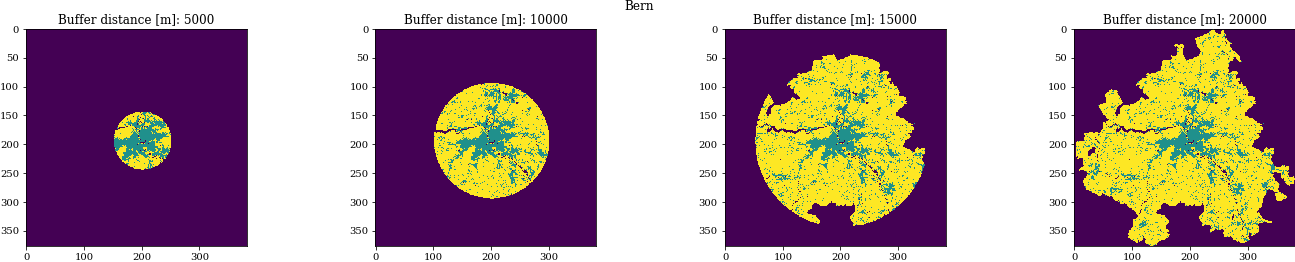

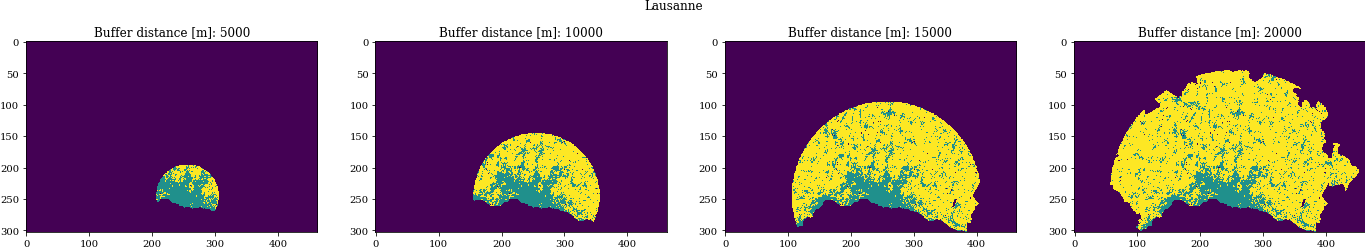

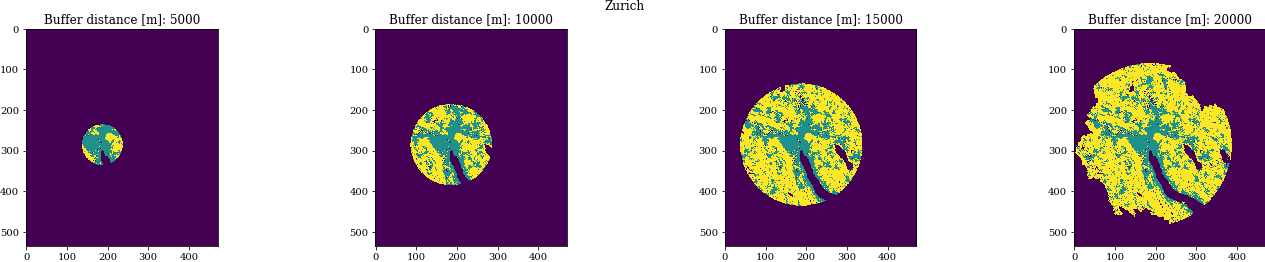

In [6]:
def plot_landscape_buffers(agglom_stba):
    num_cols = len(agglom_stba.stas)
    fig, axes = plt.subplots(1,
                             num_cols,
                             figsize=(num_cols * figwidth, figheight))

    for i in range(num_cols):
        ax = axes[i]
        # just plot for the last temporal snapshot
        agglom_stba.stas[i].landscapes[-1].plot_landscape(ax=ax)
        ax.set_title(f'Buffer distance [m]: {agglom_stba.buffer_dists[i]}')

    return fig


for agglom_slug in agglom_slugs:
    agglom_stba = agglom_dict[agglom_slug]
    fig = plot_landscape_buffers(agglom_stba)
    fig.suptitle(agglom_slug.capitalize())

## References

1. Jianguo Wu, Weijun Shen, Weizhong Sun, and Paul T Tueller. Empirical patterns of the effects of changing scale on landscape metrics. Landscape Ecology, 17(8):761–782, 2002
2. Jianguo Wu. Effects of changing scale on landscape pattern analysis: scaling relations. Landscape ecology, 19(2):125–138, 2004.